In [302]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Requirement 2: Adversarial Environment

In [383]:
# Pricing parameters
T = 200
K_prices = 30
cost = 0.5
prices = np.linspace(0,1,K_prices)
coef = np.random.uniform(0.2,0.5,T)
conversion_probability = np.zeros((T,K_prices))
for i in range(T):
    prob = np.ones(K_prices)-coef[i]*prices
    conversion_probability[i]=prob*(prob>0)
# reward_sequence = conversion_probability*(prices-cost)

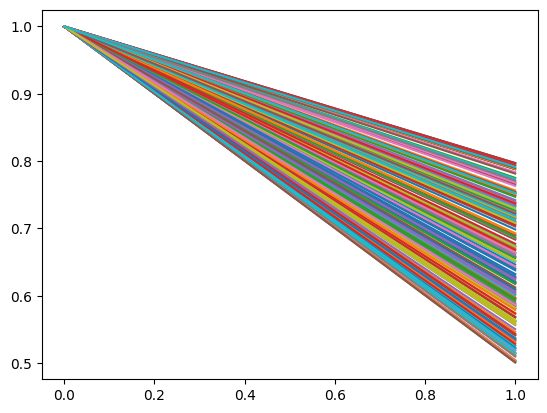

In [385]:
for i in range(T):
    plt.plot(prices,conversion_probability[i])

In [386]:
# Auctions parameters
n_users = 40       # number of users each day
K_bids = 11         # number of available bids
B = 20              # budget
rho = B/n_users     # budget per round

n_slots = 3         # number of slots
lmb = np.sort(np.array([0.6, 0.7, 0.9]))

n_advertisers = 6 #4  # number of advertisers (including us)
q = np.array([0.9, 0.7, 0.5, 0.6, 0.85, 0.65]) # ad quality
v = np.array([1.0, 1.0, 1.0, 0.85, 1.0, 0.9]) # advertisers value per click

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 0.8-np.abs(np.sin(5*t/n_users)/2)
other_bids = np.array([np.random.uniform(0.2, pattern(t), size = n_advertisers-1) for t in range(n_users)]).T
# I assume that competitors may have a larger budget than mine, but they may not deplete it.

# assuming all slots have the same prominence (probability of being clicked)
adv_ranking = np.sort(other_bids, axis=0)
m_t = adv_ranking[-n_slots]

print(len(m_t),m_t)

available_bids = np.linspace(0,1,K_bids)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

40 [0.38726793 0.64789079 0.39395555 0.45344855 0.40688686 0.44614611
 0.31106137 0.33174766 0.29894843 0.32264061 0.27221265 0.28055279
 0.25560665 0.25402824 0.2467456  0.26997803 0.23522444 0.29388613
 0.30617939 0.32593488 0.3189325  0.35226973 0.42278835 0.51506519
 0.45466067 0.47542911 0.27666364 0.38585982 0.36917904 0.25014737
 0.34287666 0.31129152 0.2882266  0.28627672 0.26148577 0.29639201
 0.24260675 0.2547526  0.21337061 0.22722963]


## Environments

In [387]:
# Princing Environment
class AdversarialExpertEnvironment:
    def __init__(self, conversion_probability):
        self.conversion_probability = conversion_probability
        self.K = len(prices)
        self.t = 0

    def round(self): # we do not need to receive a specific arm
        prob_t = self.conversion_probability[self.t, :] # we return the whole loss vector
        # d_t = np.zeros(self.K)
        # r_t = np.zeros(self.K)
        # for p in range(self.K):
        #     d_t[p] = np.random.binomial(n_clicks[p], prob_t[p])
        #     r_t[p] = prices[p]*d_t[p]-todays_cost[p]
        self.t+=1
        return prob_t

In [388]:
# Auctions Environment
class FirstPriceAuction:
    def __init__(self, ctrs, n_slots):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
        self.n_slots = n_slots

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-self.n_slots:]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        payment = values[winners]/self.ctrs[winners]
        return payment.round(2)
    
    def round(self, bids):
        winners, values = self.get_winners(bids)
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

## Agents

In [389]:
# Pricing Agent
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, r_t):
        self.weights *= np.exp(-self.learning_rate*(1-r_t))
        self.t += 1

In [390]:
# Auctions Agent

# Regret minimizer for multiplicative pacing
class RegretMinimizer_Hedge:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

# Multiplicative pacing agent
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = RegretMinimizer_Hedge(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        # self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        chosen_bid = self.bids_set[self.hedge.pull_arm()]
        return chosen_bid

    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

In [391]:
# ctrs = np.array([0.8, 0.65, 0.50, 0.75, 0.85, 0.60])
ctrs = np.ones(n_advertisers)
n_auctions= 10
auction = FirstPriceAuction(ctrs, n_slots)
for u in range(n_auctions):
    print(f'# User {u}')
    bids = np.random.choice([0.25, 0.5, 0.75, 1], size=n_advertisers)
    pub_values = bids*ctrs
    print(f'Bids: {bids}, Publisher Values: {pub_values}')
    winners, payments_per_click = auction.round(bids=bids)
    print(f'Auction Winners: {winners}, Payment-per-click: {payments_per_click}')
    print(f'Payment <= Bid : {(payments_per_click <= bids[winners]).all()}')


# User 0
Bids: [0.5  0.25 1.   0.25 0.5  0.25], Publisher Values: [0.5  0.25 1.   0.25 0.5  0.25]
Auction Winners: [0 4 2], Payment-per-click: [0.5 0.5 1. ]
Payment <= Bid : True
# User 1
Bids: [0.5  0.75 0.25 0.75 0.5  0.5 ], Publisher Values: [0.5  0.75 0.25 0.75 0.5  0.5 ]
Auction Winners: [5 1 3], Payment-per-click: [0.5  0.75 0.75]
Payment <= Bid : True
# User 2
Bids: [1.   0.25 0.25 0.25 0.25 1.  ], Publisher Values: [1.   0.25 0.25 0.25 0.25 1.  ]
Auction Winners: [4 0 5], Payment-per-click: [0.25 1.   1.  ]
Payment <= Bid : True
# User 3
Bids: [0.75 1.   0.5  0.5  1.   0.75], Publisher Values: [0.75 1.   0.5  0.5  1.   0.75]
Auction Winners: [5 1 4], Payment-per-click: [0.75 1.   1.  ]
Payment <= Bid : True
# User 4
Bids: [1.   0.5  0.5  0.5  0.75 0.5 ], Publisher Values: [1.   0.5  0.5  0.5  0.75 0.5 ]
Auction Winners: [5 4 0], Payment-per-click: [0.5  0.75 1.  ]
Payment <= Bid : True
# User 5
Bids: [0.75 0.25 0.5  0.5  0.25 0.5 ], Publisher Values: [0.75 0.25 0.5  0.5  0.25 0

## Interaction

In [403]:
pricing_learning_rate = np.sqrt(np.log(K_prices)/T) # we set the learning rate as prescribed by the theory
pricingEnv = AdversarialExpertEnvironment(conversion_probability)
# pricingEnv = AdversarialExpertEnvironment(reward_sequence)
pricingAgent = HedgeAgent(K_prices,pricing_learning_rate)

auctions_learning_rate = 1/np.sqrt(n_users)
# auctionsEnv = FirstPriceAuction(np.ones(n_advertisers), n_slots) # assuming all advertisers have the same CTR=1 ie their ads are clicked with probability 1
auctionsEnv = FirstPriceAuction(q, n_slots)

agent_reward = np.array([])
expected_agent_reward = np.array([])

reward_sequence = np.zeros((T,K_prices))
counter = 0
my_payments = np.zeros((T,n_users))
my_prices = np.zeros(T)
for t in range(T):
    # PRICING ROUND
    a_t = pricingAgent.pull_arm()
    p_t=prices[a_t]
    my_prices[t] = p_t
    buy_probabilities = pricingEnv.round()
    todays_cost = np.zeros(K_prices)
    n_clicks = np.zeros(K_prices)
    for a in range(K_prices):
        auctionsAgent = FFMultiplicativePacingAgent(available_bids, prices[a], B, n_users, auctions_learning_rate)
        # n_clicks = 0
        # todays_cost = 0
        for u in range(n_users):
            # AUCTIONS ROUND
            my_bid = auctionsAgent.bid()
            if my_bid>p_t:
                counter+=1
            all_bids = np.append(my_bid, other_bids[:, u].ravel())
            winners, payments_per_click = auctionsEnv.round(all_bids)
            # update auctions agent
            if 0 in winners:
                my_win = 1
                my_slot = np.where(winners == 0)[0]
                c_t = payments_per_click[my_slot]
                f_t = p_t-c_t
                # f_t = v[0]-c_t
                ctr = lmb[my_slot]*q[0]
            else:
                my_win = 0
                c_t = 0
                f_t = 0
                ctr = 0
            auctionsAgent.update(f_t, c_t, m_t[u])
            if random.random() < ctr:
                n_clicks[a] += 1
                my_payments[t,u] += c_t
                todays_cost[a] += c_t
        #reward_sequence[t,a] = (n_clicks[a]*prices[a]-todays_cost[a])
        # *buy_probabilities[a]
        reward_sequence[t,a] = n_clicks[a]*prices[a]*buy_probabilities[a]-todays_cost[a]
        # update reward sequence
        # for each price, compute the mean 'profit' f_t per auction (=per user)
        # for a in range(K_prices):
        #     # iterative mean over users
        #     new_value = (prices[a]-c_t)*my_win
        #     old_mean = reward_sequence[t,a]
        #     reward_sequence[t,a] = old_mean + (new_value - old_mean)/(u+1)
    # the actual profit deepens on the production cost and on the number of users that bought the product
    # for a in range(K_prices):
    #     reward_sequence[t,a] += - cost
    #     reward_sequence[t,a] *= buy_probabilities[a]*n_clicks
    # update pricing agent
    # for a in range(K_prices):
    #     reward_sequence[t,a] = (n_clicks*prices[a]-todays_cost)*buy_probabilities[a]
    #     # reward_sequence[t,a] = buy_probabilities[a]*n_clicks/n_users
    print(f'Round {t}: {n_clicks[a_t]} clicks, {round(float(todays_cost[a_t]),2)} cost, {round(float(reward_sequence[t,a_t]),2)} reward')
    pricingAgent.update(reward_sequence[a_t])
    # logging
    agent_reward = np.append(agent_reward, reward_sequence[t,a_t])
    expected_agent_reward = np.append(expected_agent_reward, (reward_sequence[t] @ pricingAgent.x_t))







Round 0: 20.0 clicks, 9.5 cost, -1.49 reward
Round 1: 15.0 clicks, 7.5 cost, -5.53 reward
Round 2: 16.0 clicks, 8.1 cost, -0.34 reward
Round 3: 20.0 clicks, 10.2 cost, -3.55 reward
Round 4: 14.0 clicks, 7.2 cost, -6.72 reward
Round 5: 18.0 clicks, 9.8 cost, 1.34 reward
Round 6: 19.0 clicks, 8.6 cost, 1.42 reward
Round 7: 17.0 clicks, 9.8 cost, -0.13 reward
Round 8: 24.0 clicks, 13.5 cost, 1.39 reward
Round 9: 17.0 clicks, 9.2 cost, -2.01 reward
Round 10: 21.0 clicks, 10.9 cost, -0.3 reward
Round 11: 18.0 clicks, 9.5 cost, -0.37 reward
Round 12: 17.0 clicks, 9.7 cost, 0.57 reward
Round 13: 16.0 clicks, 6.7 cost, -6.7 reward
Round 14: 16.0 clicks, 7.2 cost, 1.47 reward
Round 15: 20.0 clicks, 11.5 cost, 3.83 reward
Round 16: 15.0 clicks, 7.4 cost, -5.93 reward
Round 17: 18.0 clicks, 8.8 cost, 0.54 reward
Round 18: 14.0 clicks, 6.9 cost, -2.21 reward
Round 19: 21.0 clicks, 12.0 cost, -1.41 reward
Round 20: 22.0 clicks, 12.0 cost, 1.84 reward
Round 21: 24.0 clicks, 13.6 cost, -0.99 reward
R

The auctions agent bid higher than the product price 240.24 % of the time


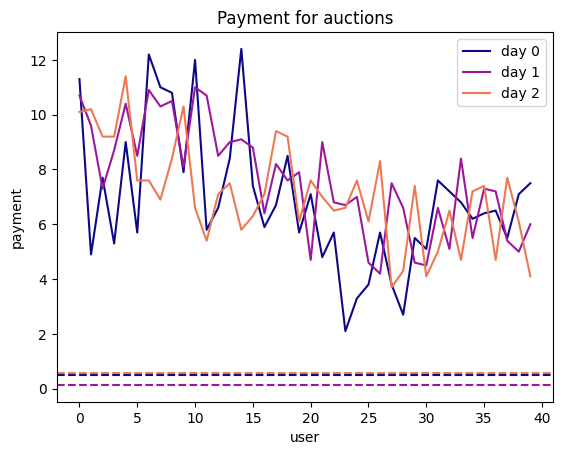

In [404]:
print(f"The auctions agent bid higher than the product price {round(100*counter/(T*n_users),2)} % of the time")

plt.title('Payment for auctions')
stop=3
for t in range(stop):
    # plt.plot(np.cumsum(my_payments[t]))
    plt.plot(my_payments[t,:], label=f'day {t}')
    plt.axhline(my_prices[t], linestyle='--')
# plt.axhline(B, color='red', linestyle='--', label='Budget')
# plt.legend()
plt.xlabel('user')
plt.ylabel('payment')
# After you plotted them, apply a random color to each curve.
import matplotlib
colormap = matplotlib.colormaps["plasma"] # The various colormaps can be found here: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax = plt.gca()
lines = ax.lines
N = len(lines)
for n in range(0, N, 2): # For each two-lines made via `plt.plot(...)`:
    random_color = colormap(n/N) # This function takes a number between 0 and 1 and returns a color.
    lines[n].set_color(random_color)
    lines[n+1].set_color(random_color)
plt.legend()
plt.show()

1.0


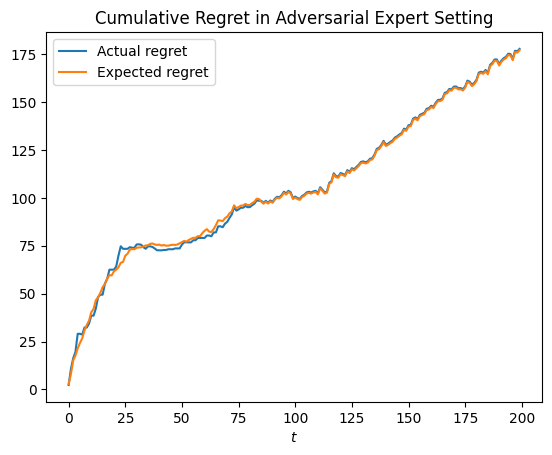

In [405]:
# Pricing performance
# reward_sequence=conversion_probability*(prices-cost)*n_users
# print(reward_sequence.shape)
best_arm = np.argmax(reward_sequence.sum(axis=0))
print(prices[best_arm])
clairvoyant_reward = reward_sequence[:, best_arm]

plt.plot(np.cumsum(clairvoyant_reward-agent_reward), label='Actual regret')
plt.plot(np.cumsum(clairvoyant_reward-expected_agent_reward), label='Expected regret')
plt.title('Cumulative Regret in Adversarial Expert Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

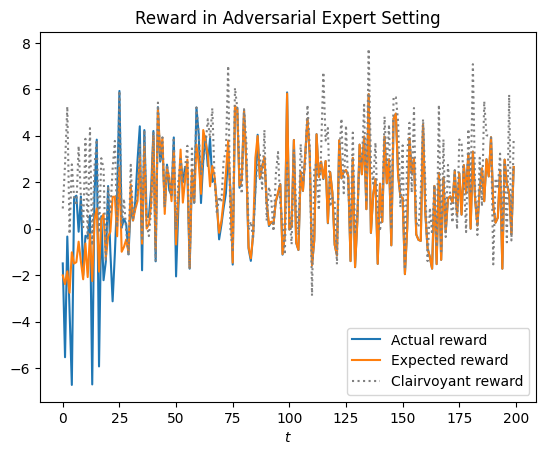

In [406]:
plt.plot(agent_reward, label='Actual reward')
plt.plot(expected_agent_reward, label='Expected reward')
plt.plot(clairvoyant_reward, label='Clairvoyant reward', linestyle=':', color='grey')
plt.title('Reward in Adversarial Expert Setting')
plt.xlabel('$t$')
plt.legend()

reward_sequence : min=-11.95332506947438, max=7.736787243689877


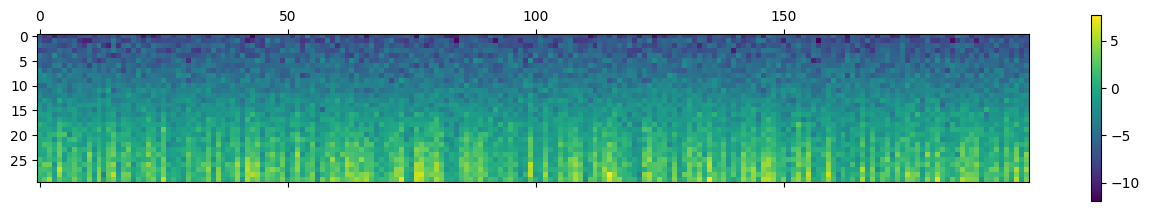

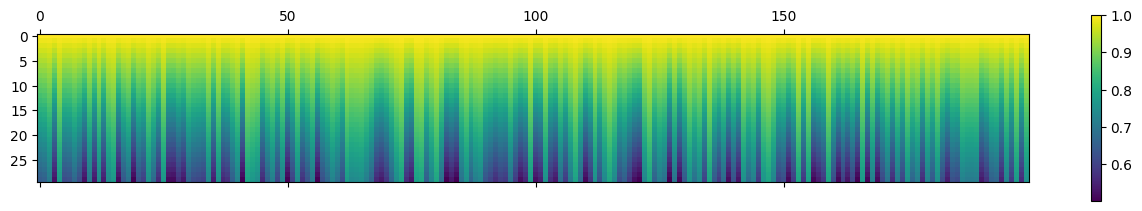

In [407]:
print(f"reward_sequence : min={reward_sequence.min()}, max={reward_sequence.max()}")
plt.matshow(reward_sequence.T)
plt.colorbar()
plt.matshow(conversion_probability.T)
plt.colorbar()